In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

In [2]:
# Define model directory (update with your path)
model_dir = "fake_news_bert_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Load model (assuming it's a classification model)
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir, local_files_only=True, attn_implementation="eager"
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [28]:
df = pd.read_csv("resource_data/fake_news_dataset_test.csv")

# Ensure expected columns exist
assert "text" in df.columns and "label" in df.columns, "Missing expected columns."

# Custom dataset class
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare dataset and DataLoader
test_dataset = FakeNewsDataset(df["text"].tolist(), df["label"].tolist(), tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

In [4]:
model.eval()

# Run predictions
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        # Move data to the same device as model
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [5]:
# Evaluate
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8386
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      2438
           1       0.88      0.66      0.76      1483

    accuracy                           0.84      3921
   macro avg       0.85      0.80      0.82      3921
weighted avg       0.84      0.84      0.83      3921



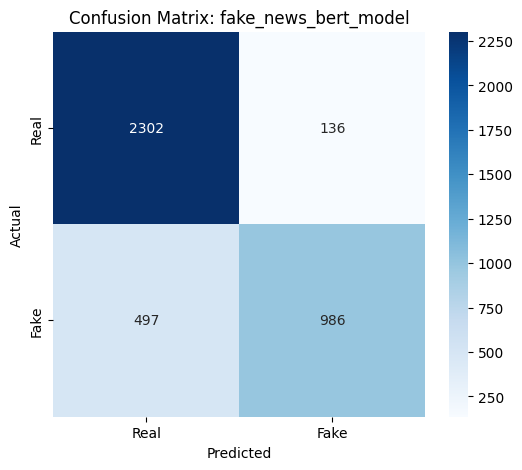

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = ['Real', 'Fake']

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title(f'Confusion Matrix: {model_dir}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

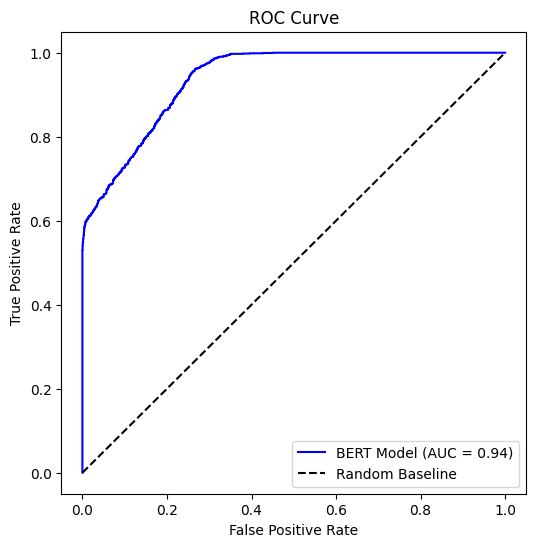

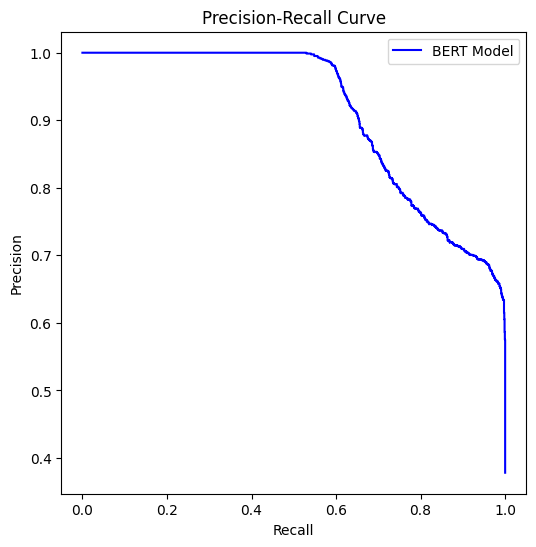

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

def get_probabilities(model, dataloader, device):
    model.eval()
    probabilities, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            probs = torch.nn.functional.softmax(logits, dim=1)[:, 1]  # Get probability for class 1 (Fake)
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(probabilities), np.array(true_labels)

y_pred_proba, y_test = get_probabilities(model, test_loader, device)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'BERT Model (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label="BERT Model", color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split dataset (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

# Create dataset and dataloader
train_dataset = FakeNewsDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = FakeNewsDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8)

# Evaluate model
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")



Validation Accuracy: 0.8510
